# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
import pickle
import xgboost as xgb

from IPython.display          import Image
from IPython.core.display     import HTML
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from matplotlib               import gridspec
from scipy                    import stats as ss
from tabulate                 import tabulate
from boruta                   import BorutaPy

from sklearn.metrics          import mean_absolute_error, mean_squared_error
from sklearn.ensemble         import RandomForestRegressor
from sklearn.linear_model     import LinearRegression, Lasso
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder


/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    

    #change dimensons plot figure with seaborn
    sns.set(rc={'figure.figsize':(15,5)})
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )    

In [3]:
jupyter_settings()

# 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('/home/mrubiatto/DS/Datascience_Em_Producao/datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/home/mrubiatto/DS/Datascience_Em_Producao/datasets/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

### 1.0 Descrição dos dados ###

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

# 1.2 Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


# 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5 Fillout NA

In [10]:
df1['competition_open_since_month'].max()

12.0

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_weak
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3:'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [12]:
df1.sample(5).T

,647946,419460,540349,728854,105893
store,917,1006,360,430,1084
day_of_week,4,6,2,1,2
date,2013-11-28 00:00:00,2014-06-21 00:00:00,2014-03-04 00:00:00,2013-09-16 00:00:00,2015-04-28 00:00:00
sales,6268,5471,8489,6957,6976
customers,756,773,861,670,893
open,1,1,1,1,1
promo,0,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,c,a,d,a


# 1.6 Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week']  = df1['promo2_since_week'].astype(int)
df1['promo2_since_year']  = df1['promo2_since_year'].astype(int)


In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
#variáveis numéricas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
#variáveis categóricas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64'])

In [17]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
217201,892,7,0,0,0,0,0,19370.0,4,2002,0,3,2015,0
931113,874,2,4771,497,1,1,1,3210.0,3,2013,0,12,2013,0


In [18]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
8819,0,d,c,"Mar,Jun,Sept,Dec",Jul
834298,0,a,c,0,Jun


In [19]:
#Central Tendency - mean, median
ct1_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2_median = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std,min,max,range,skew,kurtosis
mean = pd.DataFrame(num_attributes.apply(np.std)).T
min_ = pd.DataFrame(num_attributes.apply(np.min)).T
max_ = pd.DataFrame(num_attributes.apply(np.max)).T
range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([min_, max_, range, ct1_mean, ct2_median, skew, kurtosis]).T.reset_index()                   
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'skew', 'kurtosis']

In [20]:
m

,attributes,min,max,range,mean,median,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,-7.235657,124.071304


/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


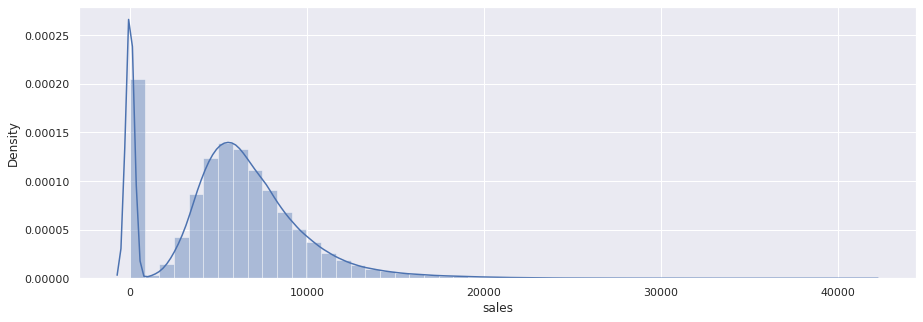

In [21]:
sns.distplot(df1['sales']);

# 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

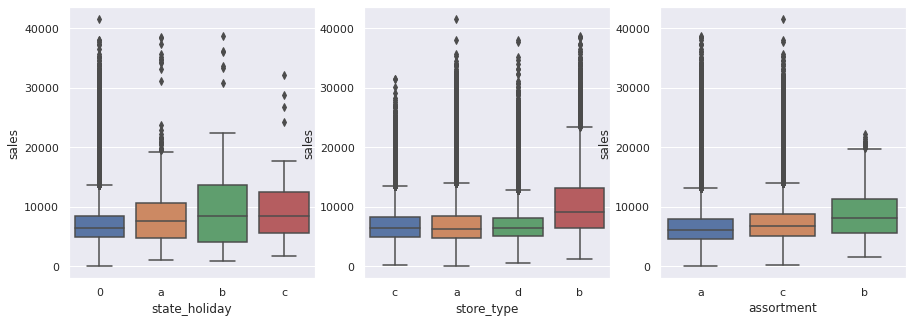

In [23]:
aux1 = df1[(df1['school_holiday'] !='0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

In [24]:
# Image('/content/drive/MyDrive/datasets/MindMapHypoteses.png');

# 2. 0 Feature Engineering

### 2.1 Criação das Hipóteses

#### 2.2.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais

#### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

In [25]:
df2 = df1.copy()
df2['date'] = pd.to_datetime(df2['date'])

### 2.1.3 Feature Engineering

In [26]:
df2.head(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12,2013,0,31,2015,0,Jul,0
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4,2013,0,31,2015,0,Jul,0
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10,2014,0,31,2015,0,Jul,0
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8,2000,0,31,2015,0,Jul,0
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9,2009,0,31,2015,0,Jul,0


In [27]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# #competition since - unir 2 colunas
df2['competition_since']= df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

# #promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x:x.days).astype(int)

#assortment
df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'Christmas' if x=='c' else 'regular_day')

/tmp/ipykernel_5298/4243802250.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [29]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0 Filtragem de variáveis

In [30]:
df3 = df2.copy()

### 3.1 Fitlragem de linhas - Não precisamos dos dias fechados das lojas para qualquer calculo

In [31]:
df3 = df3[(df3['open'] !=0 )&(df3['sales'] > 0)]

### 3.2 Seleção de colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Análise exploratória dos dados

In [33]:
df4 = df3.copy()

## 4.1 Análise Univariada

/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

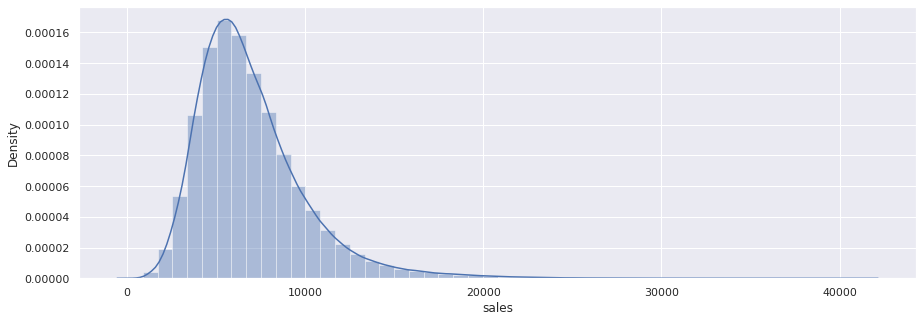

In [34]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

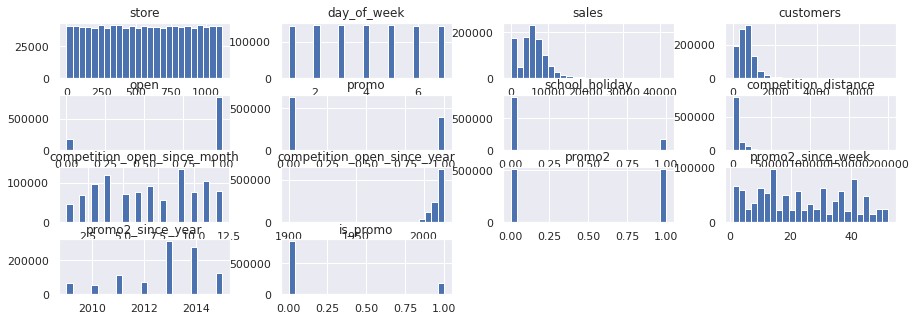

In [35]:
num_attributes.hist(bins=25);

### 4.1.3 Responsable Variable

In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and

<AxesSubplot:xlabel='sales', ylabel='Density'>

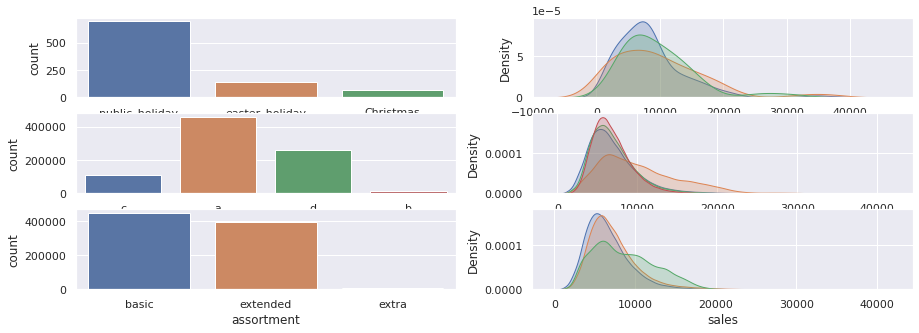

In [37]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='plublic_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)


#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Análise Bivariada

### H1.Lojas com maior sortimento deveriam vender mais

<AxesSubplot:xlabel='year_week'>

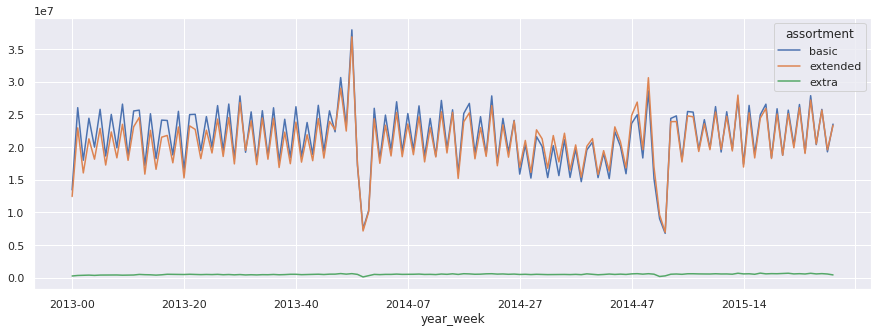

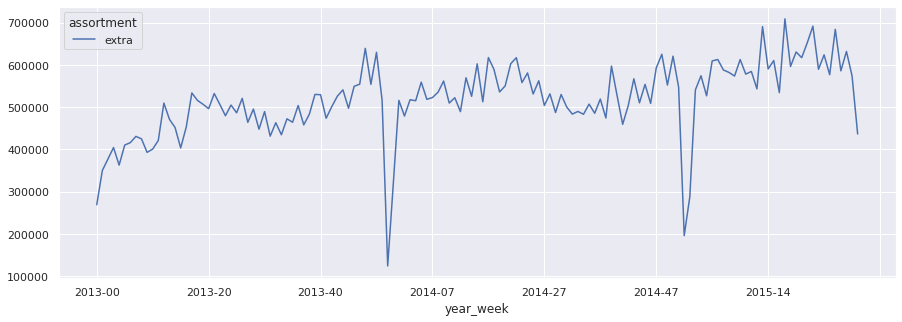

In [38]:
# Agrupamento /soma do sortimento x venda
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
# sns.barplot(x='assortment', y='sales', data=aux1)

aux2 =df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
# aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales')
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

#plot assortment extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos = FALSO, COMPETIDORES MAIS PRÓXIMOS VENDEM MAIS

<AxesSubplot:>

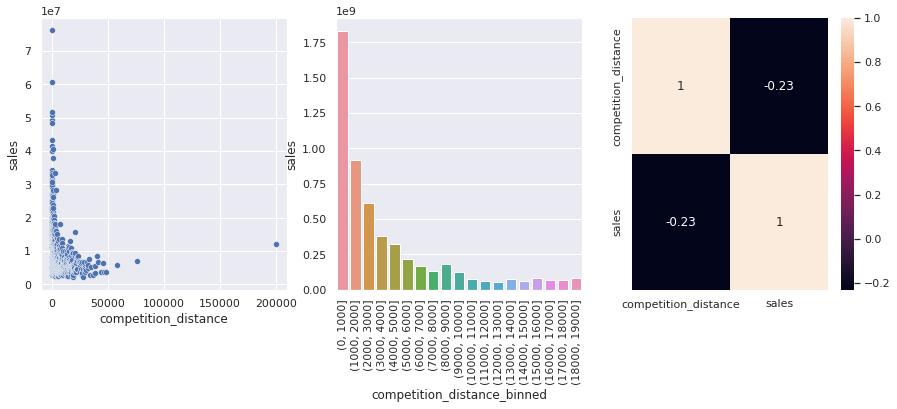

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

#vamos seperar a escala em bins para ter um melhor entendimento do gráfico pois temos muitos valores diferentes de competition distance
#criando grupos
bins = list(np.arange(0, 20000, 1000))
#colocando os grupos separados em uma nova coluna
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
#realizando o plot com a nova coluna
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H3. Lojas com competidores à mais tempo deveriam vender mais

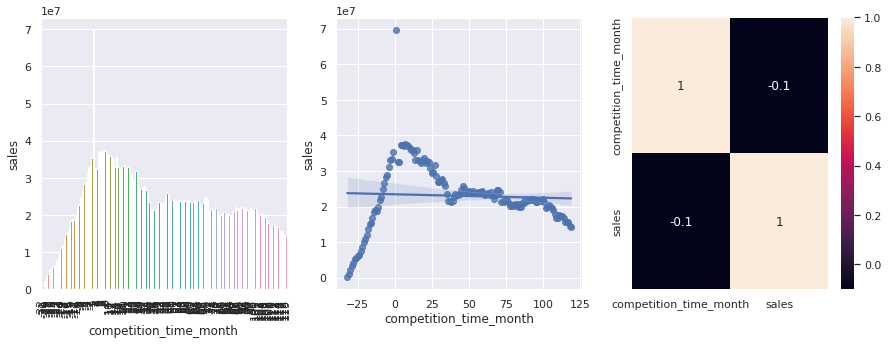

In [40]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais

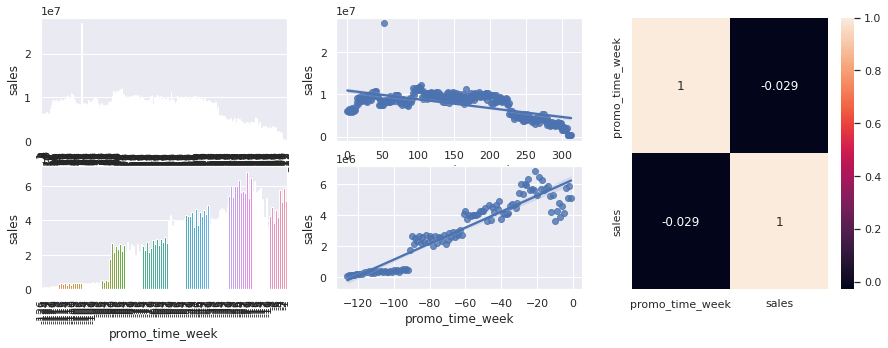

In [42]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [43]:
#H5 Lojas com mais dias de promoção deveriam vender mais
 #Iremos realizar no segundo ciclo do CRISP

### H6. Lojas com promoçoes consecutivas deveriam vender mais

In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


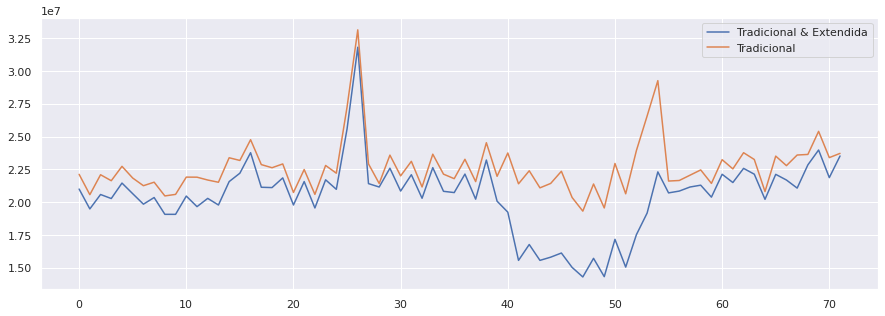

In [45]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Tradicional'])

### H9 - Lojas abertas durante o feriado de natal deveriam vender mais = FALSE

<AxesSubplot:xlabel='year', ylabel='sales'>

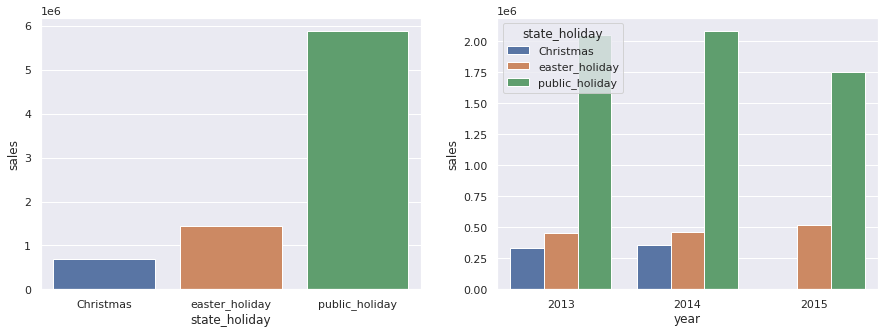

In [46]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### H10 - Lojas deveriam vender mais ao longo dos anos = FALSE

<AxesSubplot:>

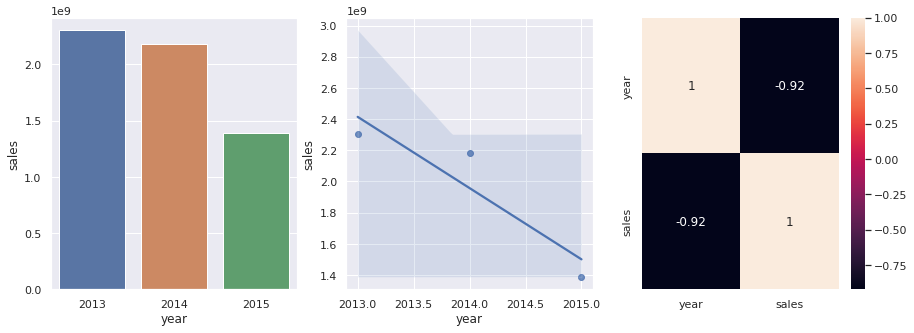

In [47]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)

### H11 - Lojas deveriam vender mais no segundo semestre do ano = FALSE

<AxesSubplot:>

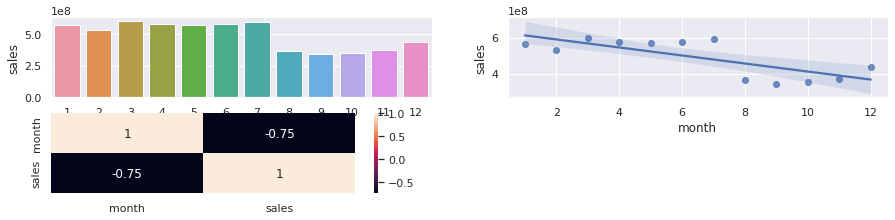

In [48]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(3,2,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(3,2,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(3,2,3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

### H12  Lojas deveriam vender mais após o dia 10 do mês = TRUE 

<AxesSubplot:xlabel='before_after', ylabel='sales'>

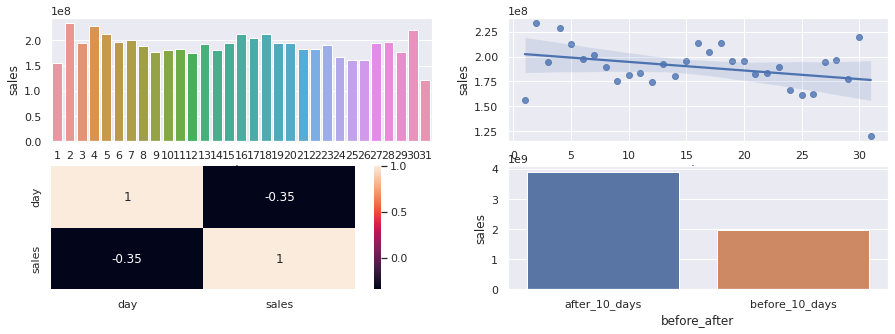

In [49]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)
            
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)            



aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2)

### H13. lojas deveriam vender menos durante os feriados escolares = True, exceto julho e agosto

<AxesSubplot:>

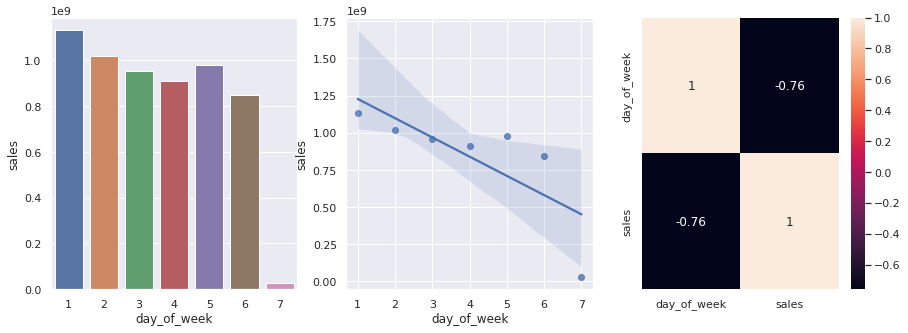

In [50]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H15. Lojas deveriam vender menos aos finais de semana = TRUE

<AxesSubplot:>

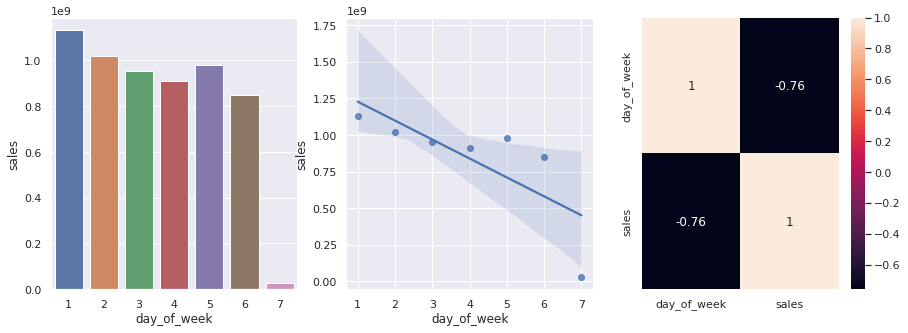

In [51]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 4.2.1 Resumo das hipoteses

In [52]:
 tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


# Resumo Final

In [53]:
# Análise Multivariada
 ## Motivação
 ## Procurar o dataset com menos dimensionalidade, excluir colunas
 ## Vetores linearmente dependentes
 ## Encontrar correlação entre as variáveis
 ## Diminuir complexidade do modelo

### 

### 4.3.1 Numerical Attributes

<AxesSubplot:>

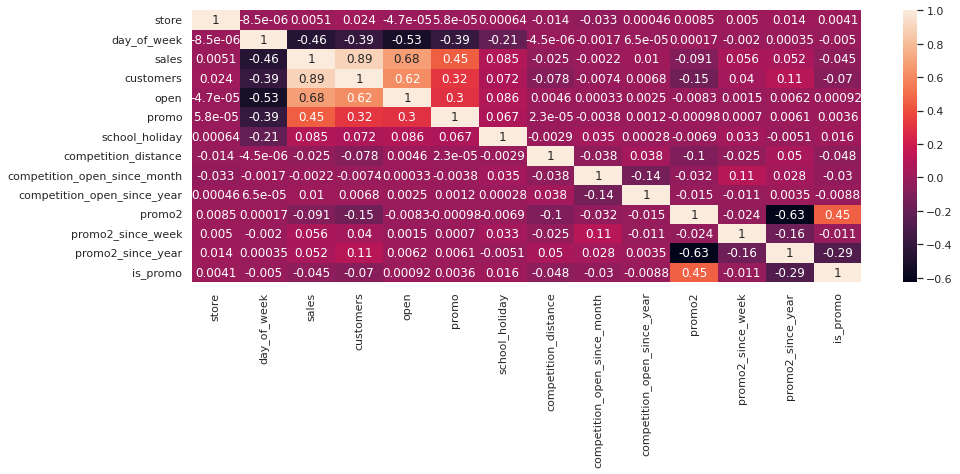

In [54]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Categorical Attributes

<AxesSubplot:>

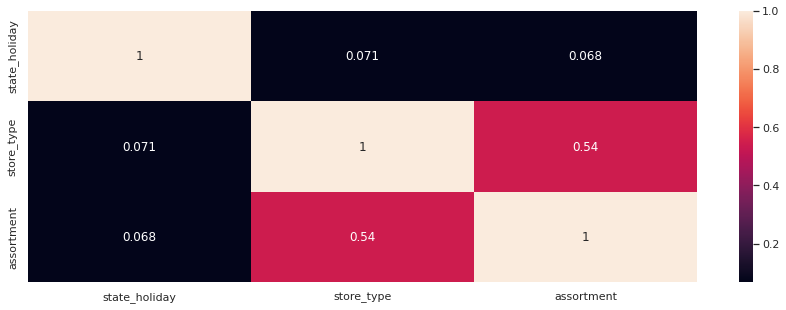

In [55]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6],'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION

In [56]:
df5 = df4.copy()

### 5.1 Normalização

### 5.2 Reiscaling

In [57]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


### 5.3 Transformação

/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance'>

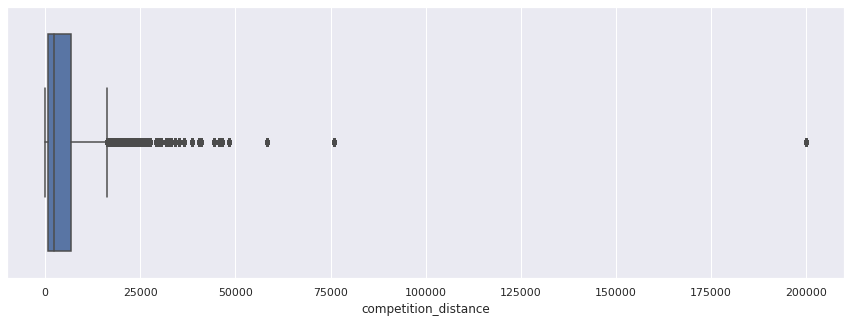

In [59]:
sns.boxplot(df5['competition_distance']) #Robust Scaler

/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

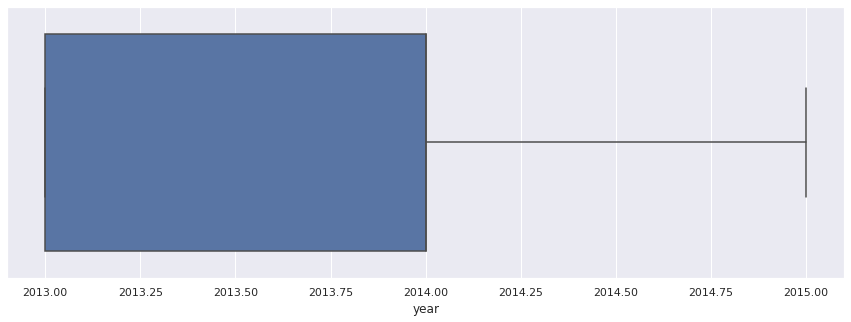

In [60]:
sns.boxplot(df5['year']);

In [61]:
rs = RobustScaler() #Verificar outliers com sns.boxplot
mms = MinMaxScaler() #Caso tenha outlier, não usaremos
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# year
df5['year'] = rs.fit_transform(df5[['year']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

/home/mrubiatto/.pyenv/versions/3.8.0/envs/Datasciencemproducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance'>

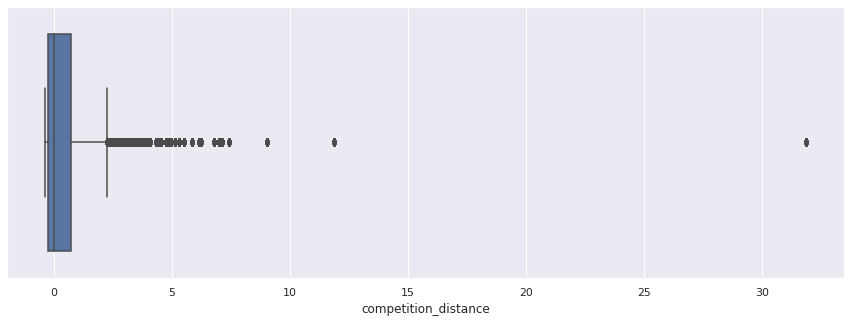

In [62]:
sns.boxplot(df5['competition_distance']);

In [67]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,3,1,2,NaN,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,3,1,0,NaN,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,3,1,0,NaN,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,3,1,2,NaN,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,3,1,0,NaN,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


## 5.3.1 Enconding

In [65]:
#state_holiday
 #one hot enconding
pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type
 #Label enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment
 #Ordinal enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3} 
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [69]:
#assortment
 #Ordinal enconding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3} 
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,3,1,2,NaN,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,3,1,0,NaN,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,3,1,0,NaN,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,3,1,2,NaN,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,3,1,0,NaN,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [78]:
## Natureza ciclica ##

# month
df5['month_sin'] = df5['month'].apply(lambda x:np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x:np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x:np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x:np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x:np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x:np.cos(x * (2. * np.pi/52)))


# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x:np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x:np.cos(x * (2. * np.pi/7)))

In [79]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,5263,1,3,1,2,NaN,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,6064,1,3,1,0,NaN,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,8314,1,3,1,0,NaN,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,13995,1,3,1,2,NaN,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,4822,1,3,1,0,NaN,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
